In [5]:
# imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

Classe 0: 4944 immagini
Classe 1: 6831 immagini
Classe 2: 6776 immagini
Classe 3: 8260 immagini
Classe 4: 2044 immagini


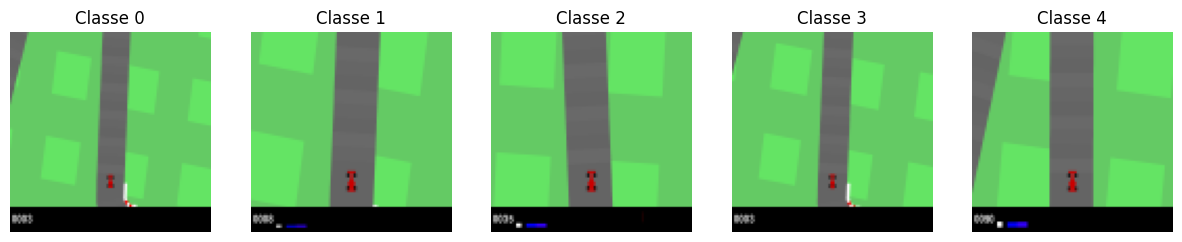

In [4]:
from PIL import Image

# Esplora distribuzione classi
root_path = "train"
classes = os.listdir(root_path)

for cls in classes:
    num_images = len(os.listdir(os.path.join(root_path, cls)))
    print(f"Classe {cls}: {num_images} immagini")

# Visualizza esempi
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for idx, cls in enumerate(classes):
    sample_path = os.path.join(root_path, cls, os.listdir(os.path.join(root_path, cls))[0])
    img = Image.open(sample_path)
    ax[idx].imshow(img)
    ax[idx].axis('off')
    ax[idx].set_title(f"Classe {cls}")
plt.show()

In [9]:
# Percorso del dataset (immagini preprocessate con data augmentation)
train_dir = "train"
test_dir = "test"

# Trasformazioni: Normalizzazione e Preprocessing finale
train_transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Assicura dimensioni coerenti
    transforms.ToTensor(),  # Converti in Tensor e scala valori [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalizzazione
    transforms.RandomRotation(degrees=5),  # Rotazione leggera
    transforms.RandomHorizontalFlip(p=0.5),  # Flip orizzontale casuale
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

test_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Creazione del Dataset
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

# Suddivisione Train/Test
#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Calcola la distribuzione delle classi
# class_counts = np.bincount([sample[1] for sample in train_dataset])
class_counts = [4944, 6831, 6776, 8260, 2044] # precomputed
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

# Calcola i pesi per ogni immagine nel dataset
sample_weights = [class_weights[label] for _, label in train_dataset]

# Crea il sampler bilanciato
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Controllo rapido
print(f"Numero di immagini nel train set: {len(train_dataset)}")
print(f"Numero di immagini nel test set: {len(test_dataset)}")
print(f"Classi disponibili: {train_dataset.classes}")


Class counts: [4944, 6831, 6776, 8260, 2044]
Class weights: tensor([0.0002, 0.0001, 0.0001, 0.0001, 0.0005])
Numero di immagini nel train set: 28855
Numero di immagini nel test set: 2749
Classi disponibili: ['0', '1', '2', '3', '4']


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Definizione della CNN
class SelfDrivingCNN(nn.Module):
    def __init__(self):
        super(SelfDrivingCNN, self).__init__()
        # Primo blocco convoluzionale
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)  # Output: 96x96x16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 48x48x16
        
        # Secondo blocco convoluzionale
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)  # 48x48x32
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 24x24x32
        
        # Terzo blocco convoluzionale
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # 24x24x64
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 12x12x64
        
        # Quarto blocco convoluzionale
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # 12x12x128
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # 6x6x128
        
        # Layer Fully-Connected
        self.fc1 = nn.Linear(6 * 6 * 128, 512)  # Fully Connected Layer
        self.dropout = nn.Dropout(0.5)  # Dropout
        self.fc2 = nn.Linear(512, 5)  # Output layer per 5 classi

    def forward(self, x):
        # Passaggio attraverso i layer convoluzionali
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        
        # Flatten delle feature maps
        x = x.view(-1, 6 * 6 * 128)
        
        # Passaggio attraverso i layer FC
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Verifica del modello
model = SelfDrivingCNN()
print(model)

# Dummy input (batch size di 32)
x = torch.randn(32, 3, 96, 96)
output = model(x)
print("Output shape:", output.shape)  # [32, 5]


SelfDrivingCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)
Output shape: torch.Size([32, 5])


In [11]:
import torch.optim as optim

# Istanziamo modello, loss e ottimizzatore
model = SelfDrivingCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()  # Training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass e aggiornamento pesi
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss, correct = 0.0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
        
        # Stampa risultati
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Accuracy: {100 * correct / len(val_loader.dataset):.2f}%")
        
    print("Training completato!")


In [12]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Accuracy sul test set: {100 * correct / total:.2f}%")

In [14]:
# Allenamento del modello
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=1)

Epoch [1/1], Train Loss: 1.0691, Val Loss: 1.8003, Accuracy: 24.45%
Training completato!


In [ ]:
# Test del modello
test_model(model, test_loader)